# Network Graphing and Centrality Calculations
Below we will: 
1. Graph the entire network of users and businesses,
2. project the user network onto the business network and calculate centrality measures of the user network, and
3. utilize the 'island method' based on degree centrality to search for networks of power users



**Load Data, Minor Exploratory Analysis and Wrangling**    
First we will load the data, conduct some minor exploratory analysis to validate that the loading process was successful, and finally perform some minor wrangling to prepare the data for graphing.

In [92]:
import pickle
import urllib.request
import requests
import pandas as pd
import sys
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite

#loading data from github
url_business = "https://github.com/justinm0rgan/webanalytics/raw/main/final_project/data/business_df_nyc.pkl"
url_reviews = "https://github.com/justinm0rgan/webanalytics/raw/main/final_project/data/reviews_df_nyc.pkl"
file_name_business, headers = urllib.request.urlretrieve(url_business)
file_name_reviews, headers = urllib.request.urlretrieve(url_reviews)

# Load the data from the pickle file
with open(file_name_business, "rb") as file_business:
    business_data = pickle.load(file_business)

with open(file_name_reviews, "rb") as file_reviews:
    review_data = pickle.load(file_reviews)    

Now that the data is loaded we will create two dataframes and briefly look at each:
- one for businesses
- one for reviews

In [93]:
# business df
business_df = pd.DataFrame(business_data)

# reviews df
review_df = pd.DataFrame(review_data)


Interestingly, the variable 'review_user' consists of the first name of the user, followed by space, then followed by last initial, ie 'Robert S.'.  This method of documenting a user name may be problematic  for downstream analysis since it increases the likelihood of two users sharing the same first name and last initial.  Although a unique variable user identifier, 'review_user_id', is present, if we want to refer to a node in the analysis, refering to a string would reduce readability.

Let's check to see if two different users are referred to by an identical 'review_user' value.

In [67]:
unique_count = review_df['review_user_id'].nunique()
print("Unique count of 'review_user_id':", unique_count)

unique_count = review_df['review_user'].nunique()
print("Unique count of 'review_user':", unique_count)


count = len(review_df)
print("Total number of rows in User DataFrame:", count)



Unique count of 'review_user_id': 1673
Unique count of 'review_user': 1589
Total number of rows in User DataFrame: 1941


Yes. It appears users do share the same 'first name and last name initial' combination. We will create a new variable to solve this problem. First we replaced the space and period with the underscore symbol ('_') and then create a slightly more readable username,'unique_user_name', by concatinating 'review_user' field with the first five characters in 'review_user_id'.

In [68]:
# Remove spaces and drop periods from 'review_user' column
review_df['review_user'] = review_df['review_user'].str.replace(' ', '_')
review_df['review_user'] = review_df['review_user'].str.replace('.', '_')

# Create a new column 'unique_user_name' by concatenating 'review_user' and the first five characters of 'review_user_id'
review_df['unique_user_name'] = review_df['review_user'] + review_df['review_user_id'].str[:5]

# Display the updated DataFrame
print(review_df['unique_user_name'].head(3))
#print(review_df.dtypes)

0     Carol_S_fGa2U
1    Nicole_D_RbwbM
2      Lina_F_8302q
Name: unique_user_name, dtype: object


C:\Users\maric\AppData\Local\Temp\ipykernel_22704\1676745885.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  review_df['review_user'] = review_df['review_user'].str.replace('.', '_')


Now the number of unqiue values in 'review_user_id' and 'updated_user_name' should be equal. Let's check. 

In [69]:
unique_count = review_df['review_user_id'].nunique()
print("Unique count of 'review_user_id':", unique_count)

unique_count = review_df['unique_user_name'].nunique()
print("Unique count of 'unique_user_namer':", unique_count)


count = len(review_df)
print("Total number of rows in User DataFrame:", count)


Unique count of 'review_user_id': 1673
Unique count of 'unique_user_namer': 1673
Total number of rows in User DataFrame: 1941


Yes now they are equal.

Finally, let's left join the dataframes together and check to make sure the number of rows remains 1,941 to validate.

In [70]:
restaurant_df = review_df.merge(business_df, how='left', on=['business_id'])
restaurant_df = restaurant_df.drop_duplicates()
count = len(review_df)
print("Total number of rows in User DataFrame:", count)

Total number of rows in User DataFrame: 1941


**Graphing the Entire Network of Users and Businesses**    
Below, the entire network is plotted.  Reviewers are represented by red nodes and businesses are represented by blue nodes.  The bipartite nature of the graph is confirmed, but there are some nodes which do not have an edge. These nodes with no edges will be accounted for in downstream analysis

False
True


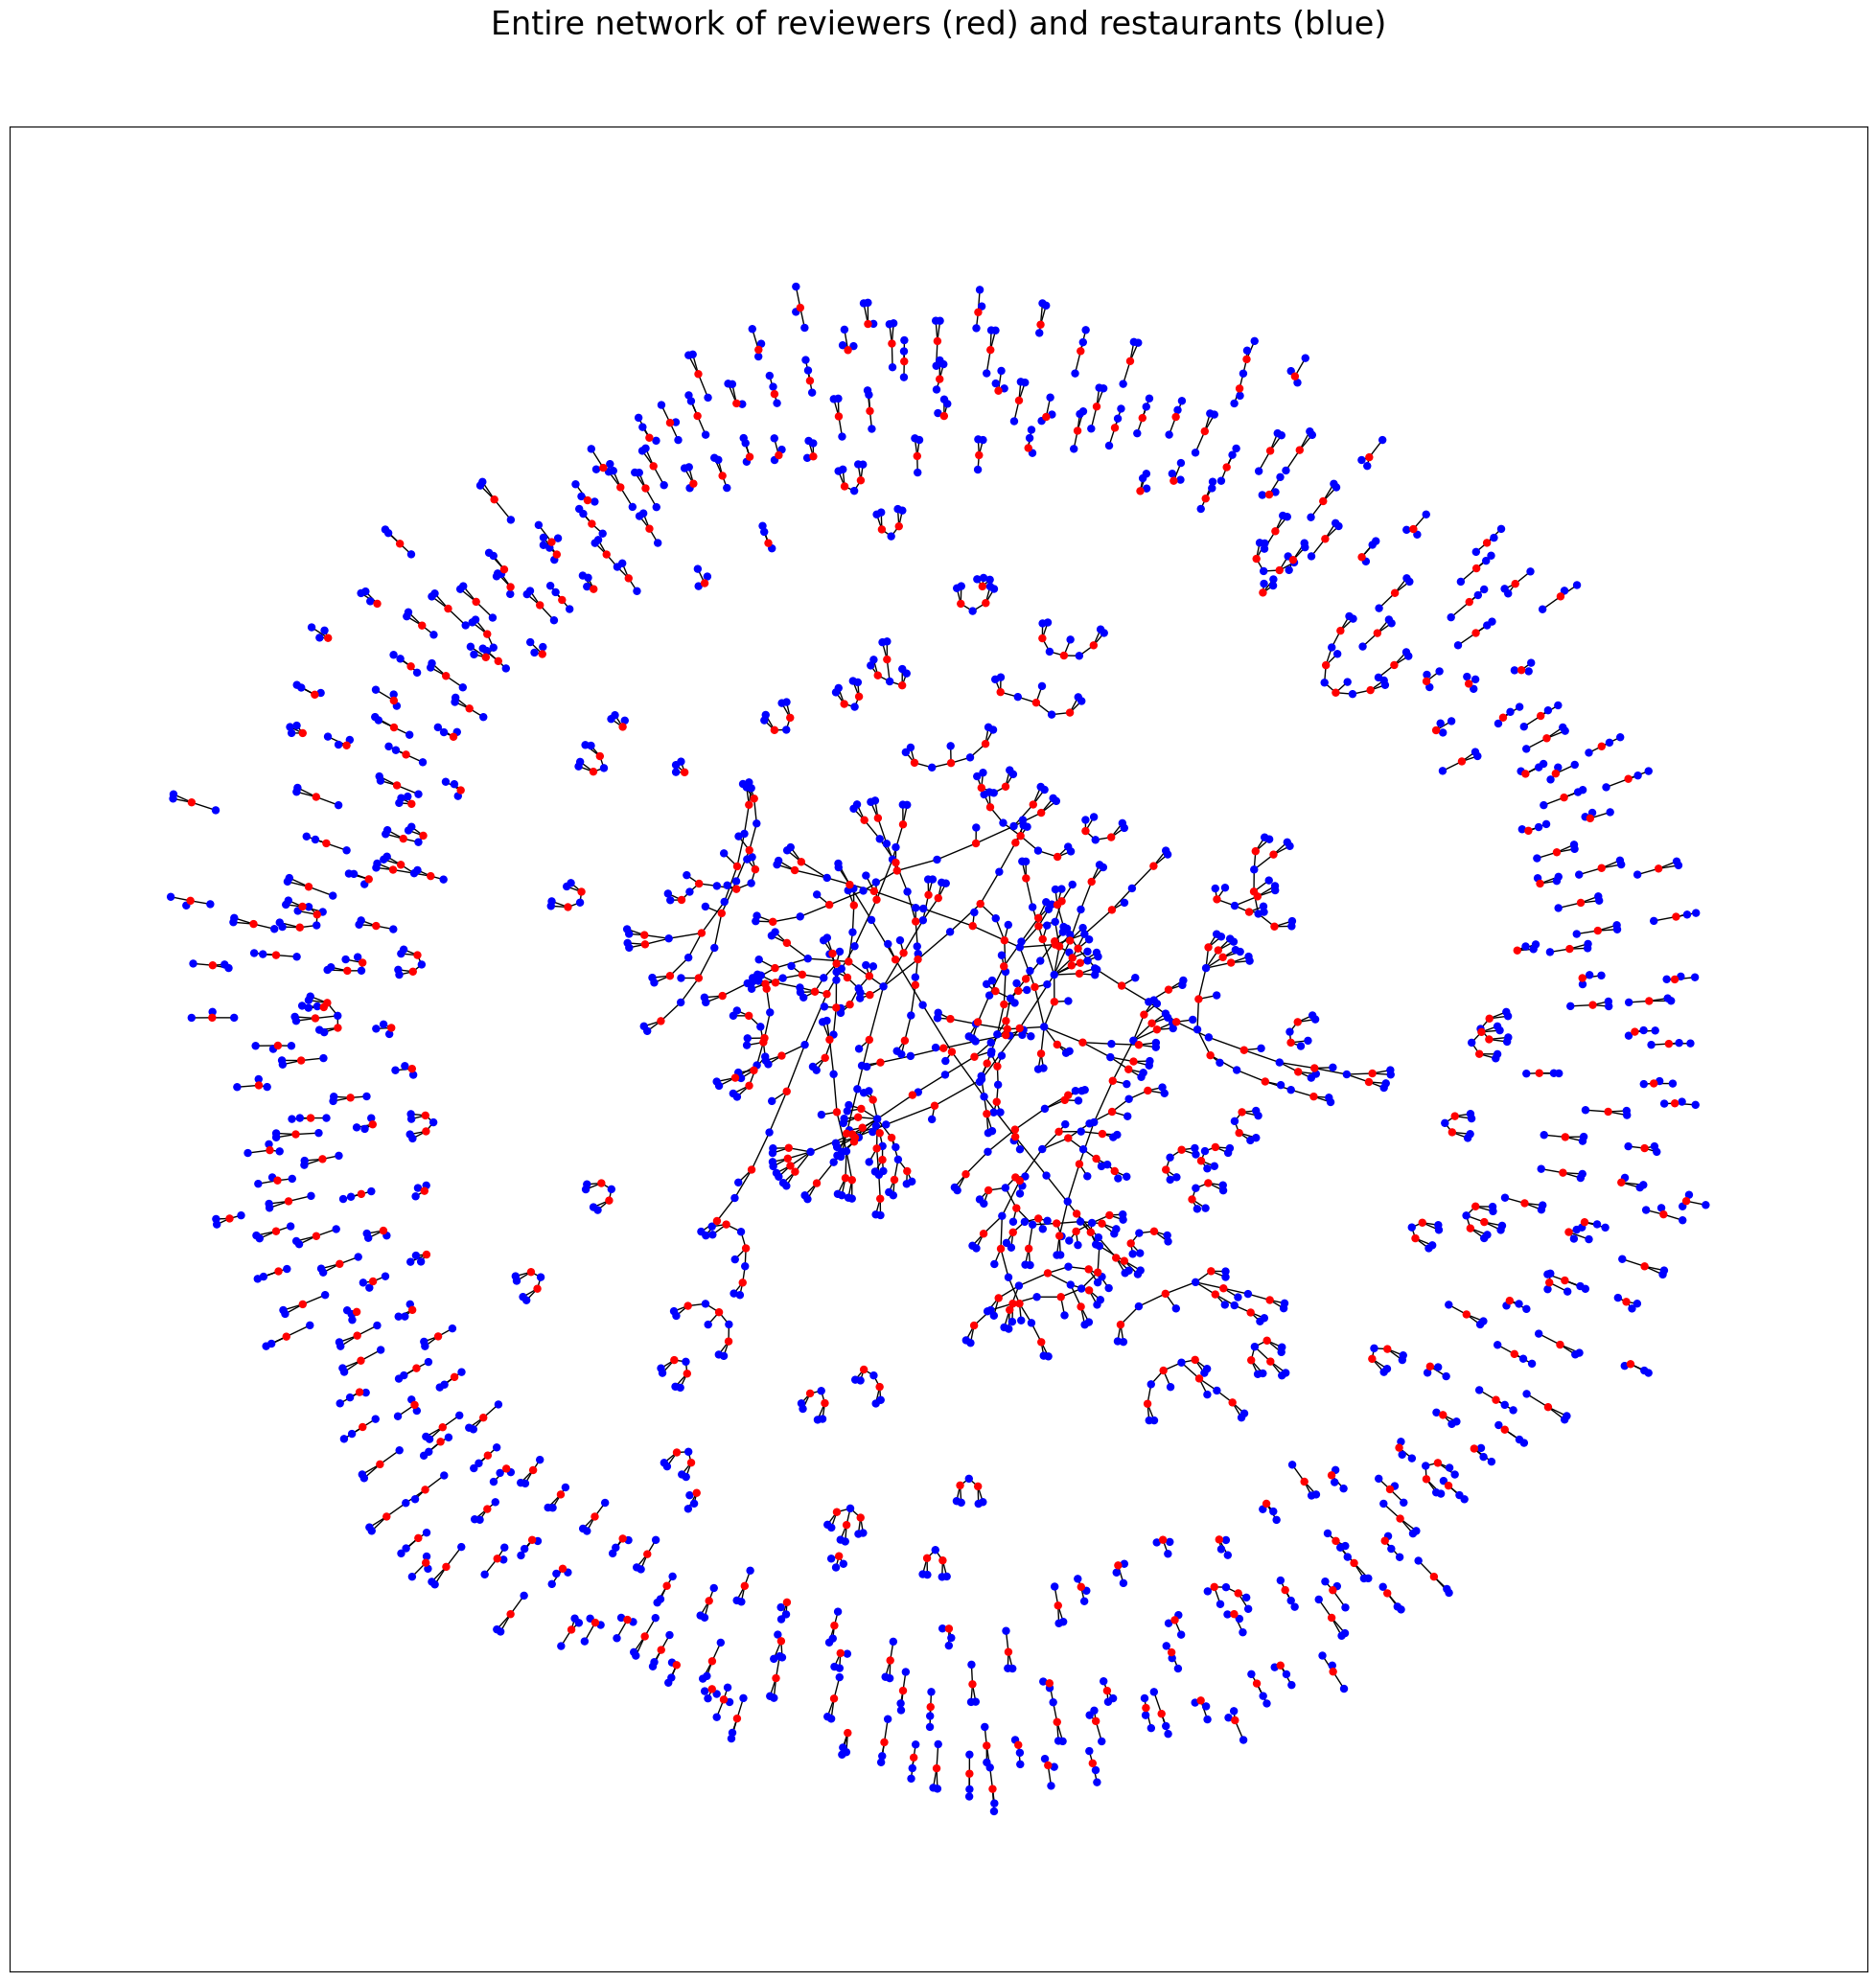

In [71]:
#Create the bipartite graph
graph = nx.Graph()
 
plt.show()
graph.add_nodes_from(restaurant_df['review_user_id']       ,bipartite=1, with_labels=False)
graph.add_nodes_from(restaurant_df['business_id'],bipartite=0, with_labels=False)
#tesing data- for each node there is at least one edge
print(nx.is_connected(graph))

#Returns True if graph G is bipartite, False if not.
print(nx.is_bipartite(graph)) 
node_colors = ['blue' if node_type == 1 else 'red' for node_type in nx.get_node_attributes(graph, 'bipartite').values()]

for i in range(len(restaurant_df)):
  graph.add_edges_from([(restaurant_df.iloc[i,1],restaurant_df.iloc[i,0])])

plt.figure(figsize=(25,25))
plt.text(0.5, 1.05, "Entire network of reviewers (red) and restaurants (blue)", fontsize=24, ha='center', transform=plt.gca().transAxes)
nx.draw_networkx(graph, with_labels=False, node_size=25,node_color=node_colors)
plt.show()


   

**Centrality Calculations**

Below, the user network is projected on the business network and centrality measures are calculated for the user network.  There are 768 rows meaning centrality measurements have been calculated for each user.

In [72]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)


#centrality calculations

W  = bipartite.projected_graph(graph, restaurant_df['review_user_id'])
C  = nx.closeness_centrality(W) 
B  = nx.betweenness_centrality(W) 
D  = nx.degree_centrality(W)
E  = nx.eigenvector_centrality(W)
#weighted
#W_weighted = bipartite.weighted_projected_graph(graph, merged_df['Organisation'])
#C_weighted  = nx.closeness_centrality(W2) 
#B_weighted  = nx.betweenness_centrality(W2) 
#D_weighted  = nx.degree(W2)
#E_weighted  = nx.eigenvector_centrality(W2)
#degee_cent=nx.degree_centrality(df)


data = []
for w in restaurant_df['review_user_id']:
    cent_degree = W.degree(w)
    #Organisation_degree_weighted = W_weighted (w, weight='weight')
    Closeness_value = C[w]
    #Closeness_value_weighted=C_weighted[w]
    Betweeness=B[w]
    #Betweeness_weighted=B_weighted[w]
    Degree=D[w]
    #Degree_weighted=D_weighted[w]
    Eigenvector=E[w]
    #Eigenvector_weighted=E_weighted[w]
    
    data.append((w 
                 ,cent_degree#,Organisation_degree_weighted
                 ,Closeness_value#, Closeness_value_weighted      
                 ,Betweeness#, Betweeness_weighted
                 ,Degree#,Degree_weighted
                 ,Eigenvector#,Eigenvector_weighted
                ))

df1 = pd.DataFrame(data, columns=["review_user_id"
                                 ,"Degree"#,"Degree_Weighted"
                                 ,"Closeness"#,"Closeness Centrality Weighted"
                                 ,"Betweeness"#,"Betweenness Centrality Weighted"
                                 ,"Degree_Cent"#,"Degree Centrality Weighted"
                                 ,"Eigenvector"#,"Eigenvector_weighted"
                                ]
                                )

df1 = df1.drop_duplicates()
sorted_df1 = df1.sort_values(by='Degree', ascending=False)
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
sorted_df1

,review_user_id,Degree,Closeness,Betweeness,Degree_Cent,Eigenvector
1246,jZoC7tuPaoEFduT8jUQnag,18,0.019557,0.001472,0.010766,5.436643e-01
1334,CTAML26-nMaMRWyq4VrFsA,18,0.017300,0.001423,0.010766,9.976810e-02
1287,RLHvF8bRcnU4uEMohBvIow,12,0.018807,0.001199,0.007177,3.179370e-01
255,SqVUNVeYJblyoUz4e-Fiqw,10,0.008641,0.000464,0.005981,7.756947e-10
1267,rKEtVvgJGL3mu2YYv6wF8w,10,0.015162,0.000515,0.005981,4.993982e-02
...,...,...,...,...,...,...
654,Lh7KVMJ8MMf6DK77eP-Q_g,2,0.001196,0.000000,0.001196,2.253356e-30
652,xowhgBgV6NtkeOyZ9Z8otw,2,0.002153,0.000000,0.001196,2.373927e-19
651,qc4WYzRr38FOerfXuV9SpQ,2,0.002153,0.000000,0.001196,2.373927e-19
649,sXNaC_NTRPD6Rez5Pe0mtg,2,0.002791,0.000000,0.001196,8.184764e-17


Closeness, betweeness, and eigenvector centralities appear a little low.  However there are some users who have much more degree centrality than others.  Let's plot 'Degree' as a bar graph to visualize this difference.

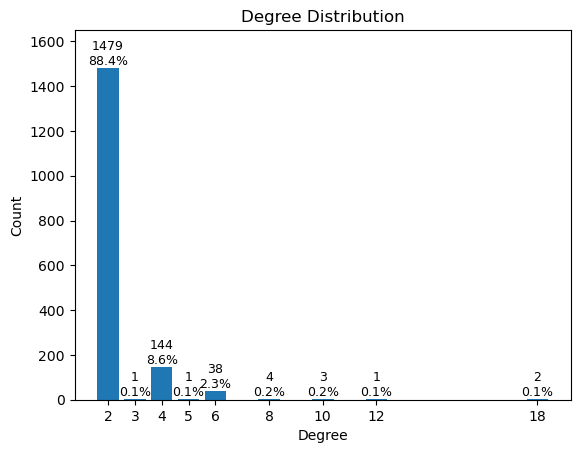

In [77]:
degrees = sorted_df1['Degree']
degree_counts = degrees.value_counts()
degree_counts = degree_counts.sort_index()
plt.bar(degree_counts.index, degree_counts.values)
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree Distribution')

plt.xticks(degree_counts.index, map(int, degree_counts.index))

for i, count in enumerate(degree_counts.values):
    percentage = count / len(degrees) * 100
    plt.text(degree_counts.index[i], count + 1, f'{count}\n{percentage:.1f}%',
             ha='center', va='bottom', fontsize=9)

plt.ylim(0, 1650)

plt.show()

Of note:
- 88.4% of users have a degree measurement of 2. This means a significant majority of reviewers (88.4%, count=1479 reviewers) have only reviewed two restaurants.
- 8.6% of users have a degree measurement of 4.  This means a 8.6% of reviewers (count=144) have only reviewed four restaurants.
- Users who have a degree measure of 2 or 4 compose 97% of the dataset.  The dataset is significantly skewed to users with these two degree measures.

**The Island Method Applied to the User Network**     
Let's visualize the different networks based on degree by using the 'island method' to look for power users.

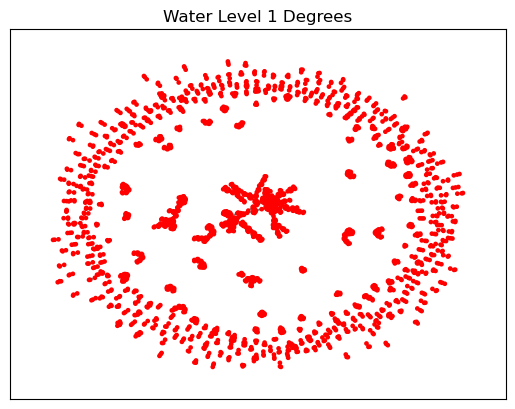

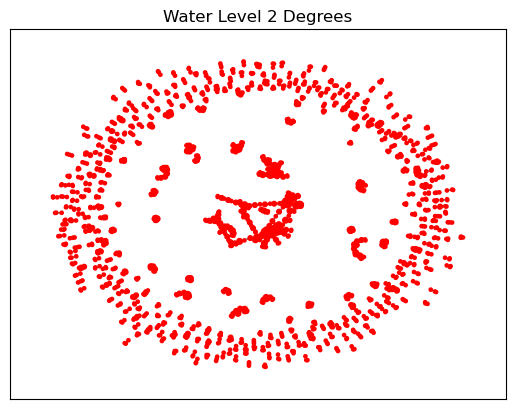

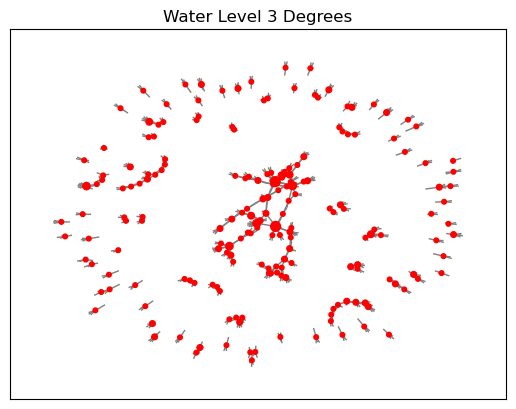

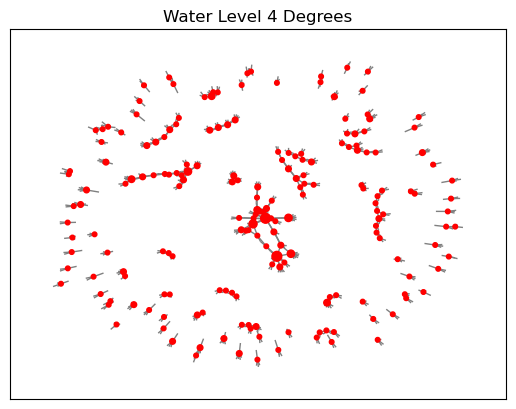

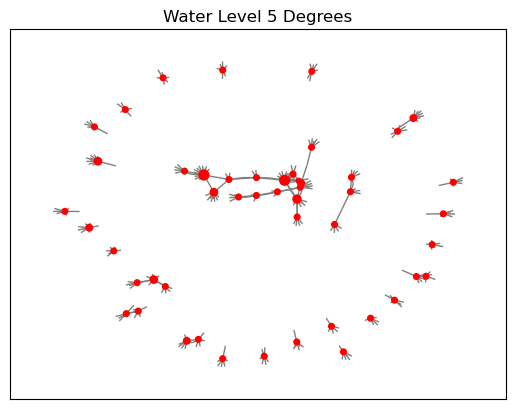

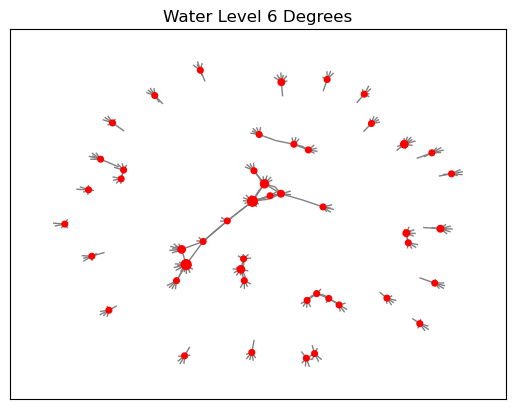

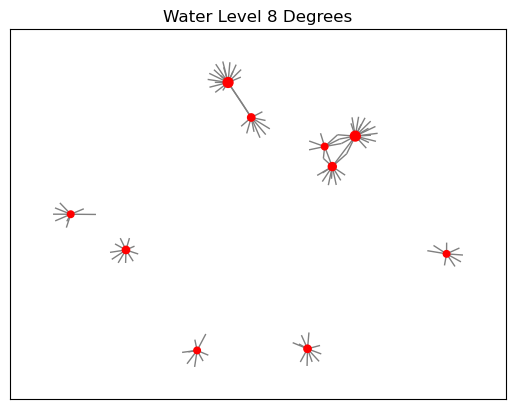

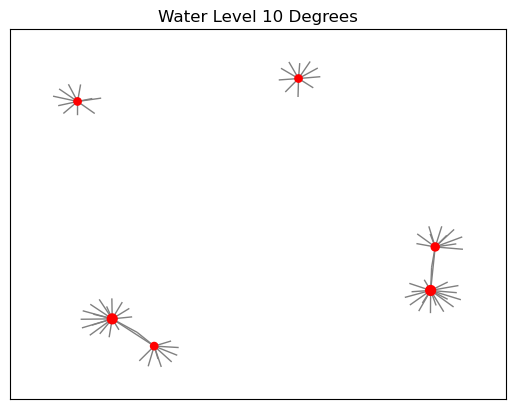

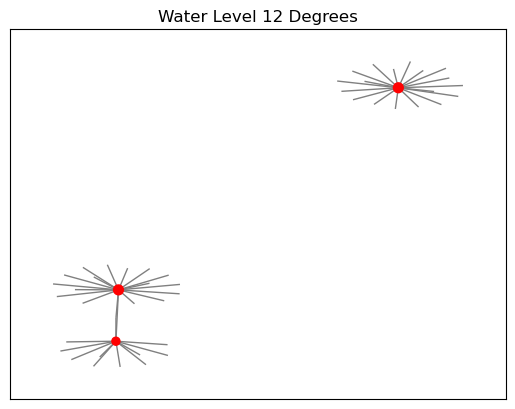

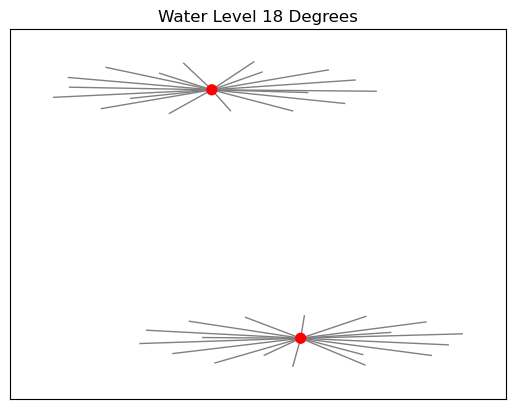

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite

def plot_water_level(graph, df, water_level):
    greater_than = df.loc[df['Degree'] >= water_level]
    W = bipartite.projected_graph(graph, greater_than['review_user_id'])
    
    islands = []
    visited = set()
    for node in greater_than['review_user_id']:
        if node not in visited:
            island = nx.node_connected_component(W, node)
            islands.append(island)
            visited.update(island)
    
    level_graph = nx.Graph()
    for island in islands:
        level_graph.add_edges_from(W.subgraph(island).edges())
    
    pos = nx.spring_layout(level_graph)
    
    degree_centrality_values = greater_than.set_index('review_user_id')['Degree']
    max_degree = np.max(degree_centrality_values.values)
    node_sizes = [degree_centrality_values.get(node, 0) / max_degree * 50 for node in level_graph.nodes()]
    
    plt.figure()
    nx.draw_networkx(level_graph,
                     pos,
                     with_labels=False,
                     node_color='red',
                     node_size=node_sizes,
                     edge_color='gray',
                     font_size=8)
    plt.title(f"Water Level {water_level} Degrees")
    plt.show()

# Example usage
plot_water_level(graph, sorted_df1, 1)
plot_water_level(graph, sorted_df1, 2)
plot_water_level(graph, sorted_df1, 3)
plot_water_level(graph, sorted_df1, 4)
plot_water_level(graph, sorted_df1, 5)
plot_water_level(graph, sorted_df1, 6)
plot_water_level(graph, sorted_df1, 8)
plot_water_level(graph, sorted_df1, 10)
plot_water_level(graph, sorted_df1, 12)
plot_water_level(graph, sorted_df1, 18)


It looks like power user networks become more apparent once the waterlevel is raised to 8 degrees. 

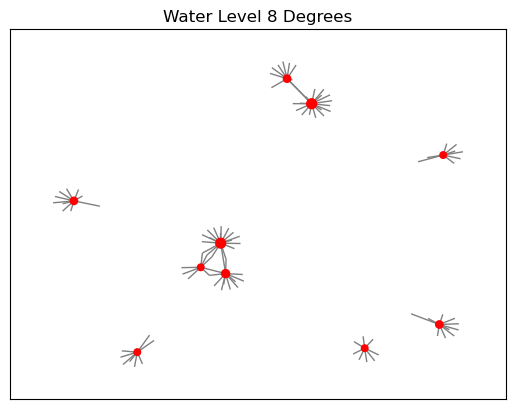

In [88]:
plot_water_level(graph, sorted_df1, 8)

The users who reviewed the highest number of resturants, and for this reason may be considered power users, do not appear to share a common restaurant.

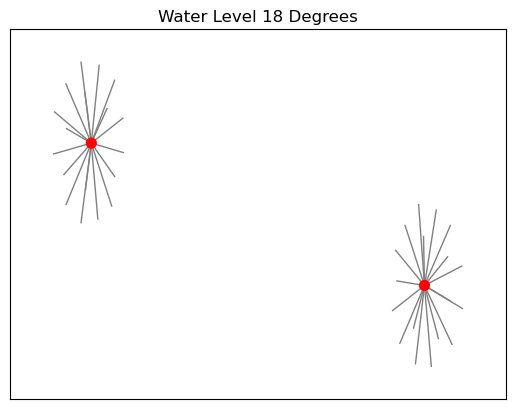

In [89]:
plot_water_level(graph, sorted_df1, 18)

In [94]:
# Define the file path with the directory
file_path = r'C:\Users\maric\Documents\CUNYDataScience\620\webanalytics\final_project\data\centrality_df_nyc.pkl'

# Pickle the DataFrame to the specified file path
sorted_df1.to_pickle(file_path)